<a href="https://colab.research.google.com/github/Sylvariane/Kaggle_cryptocurrencies_forecasting/blob/main/P08_02_notebookmodelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# G-Research Cryptocurrencies : Modelisation

- Utils.

In [2]:
# system libraries
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc

# data manipulation libraries
import pandas as pd
import numpy as np

# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# modelisation libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE, MAPE & R² score  
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("MAPE: ", mape.round(5))

In [4]:
dtype_dict = {"H-L" : "float16",
              "O-C" : "float16",
              "MA_7d" : "float16", 
              "MA_14d" : "float16",
              "MA_21d" : "float16",
              "STD_7d" : "float16"}

In [5]:
path = '/content/drive/My Drive/Ingénieur ML - OC/P8/datasets/new_df/'

## 1) Data Preprocessing

In [6]:
merged_df = pd.read_csv(path+"bitcoin.csv",
                        dtype = dtype_dict)
print(merged_df)

                   timestamp asset_name  ...         FRAMA        RSI
0        2018-01-01 00:01:00    Bitcoin  ...  13850.176000        NaN
1        2018-01-01 00:02:00    Bitcoin  ...  13828.102000   0.000000
2        2018-01-01 00:03:00    Bitcoin  ...  13801.314000   0.000000
3        2018-01-01 00:04:00    Bitcoin  ...  13768.040000   0.000000
4        2018-01-01 00:05:00    Bitcoin  ...  13724.914000   0.000000
...                      ...        ...  ...           ...        ...
2099955  2021-09-20 23:42:00    Bitcoin  ...  42705.627973  51.298112
2099956  2021-09-20 23:43:00    Bitcoin  ...  42706.257587  46.840248
2099957  2021-09-20 23:43:00    Bitcoin  ...  42706.853047  46.840248
2099958  2021-09-20 23:44:00    Bitcoin  ...  42705.729355  40.458654
2099959  2021-09-20 23:44:00    Bitcoin  ...  42704.069730  40.458654

[2099960 rows x 22 columns]


In [8]:
merged_df.fillna(0, inplace=True)

In [9]:
merged_df.drop(["asset_name", "vwap", "count",
          "open", "close", "high",
          "low", "volume", "log_open",
          "FRAMA", "RSI", "log_close",
          "log_low", "log_high"],
          axis=1, inplace=True)

In [10]:
merged_df.set_index("timestamp", inplace=True)

In [11]:
train_set = merged_df.loc[merged_df.index <= "2021-06-20 23:59:00"]
test_set = merged_df.loc[merged_df.index >= "2021-06-21 00:00:00"]

train_set = train_set.reset_index()
train_set.drop("timestamp", axis=1, inplace=True)

test_set = test_set.reset_index()
test_set.drop("timestamp", axis=1, inplace=True)

y_train = train_set["target"]
X_train = train_set.drop("target", axis=1)

y_test = test_set["target"]
X_test = test_set.drop("target", axis=1)

In [12]:
del train_set,\
    test_set,\
    merged_df
gc.collect()

150

In [13]:
#cat_var = ["asset_name"]
num_var = ["H-L", "O-C", "MA_7d",
           "MA_14d", "MA_21d", "STD_7d"]

In [14]:
"""cat_pipe = Pipeline([
    ('encoder', OneHotEncoder())
])
"""
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler())
])

preprocessing_pipe = ColumnTransformer(
    transformers=[
    #("cat", cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [15]:
X_train = preprocessing_pipe.fit_transform(X_train)

## 2) Modelisation with Machine Learning methods

### a) Linear Regression

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [17]:
X_test = preprocessing_pipe.transform(X_test)

In [18]:
y_pred = lin_reg.predict(X_test)

In [19]:
regression_metrics(y_test, y_pred)

MAE:  0.00106
MSE:  0.0
RMSE:  0.0015838061154032916
MAPE:  1.24315


In [20]:
del y_pred, lin_reg
gc.collect()

301

### b) Random Forest

In [21]:
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
y_pred = rf_reg.predict(X_test)
regression_metrics(y_test, y_pred)

MAE:  0.00125
MSE:  0.0
RMSE:  0.0018076115962703508
MAPE:  8.08519


In [23]:
del y_pred,\
    rf_reg,\
    X_train,\
    X_test,\
    y_train,\
    y_test

gc.collect()

148

## 3) Modelisation with Deep Learning methods

### a) ANN according to Vijdha et al. (2020)

In [24]:
from tensorflow import keras
import tensorflow as tf
import datetime

In [25]:
merged_df = pd.read_csv(path+"bitcoin.csv",
                        dtype = dtype_dict)

In [26]:
merged_df.fillna(0, inplace=True)

In [27]:
merged_df.drop(["asset_name", "vwap", "count",
          "open", "close", "high",
          "low", "volume", "log_open",
          "FRAMA", "RSI", "log_close",
          "log_low", "log_high"],
          axis=1, inplace=True)

In [28]:
merged_df.set_index("timestamp", inplace=True)

In [29]:
train_features = merged_df.loc[merged_df.index <= "2021-06-20 23:59:00"]
train_features = train_features.reset_index()
train_features.drop("timestamp", axis=1, inplace=True)
train_labels = train_features["target"]
train_features = train_features.drop("target", axis=1)
train_features = np.asarray(train_features).astype("float32")

In [41]:
test_features = merged_df.loc[merged_df.index <= "2021-06-20 23:59:00"]
test_features = test_features.reset_index()
test_features.drop("timestamp", axis=1, inplace=True)
test_labels = test_features["target"]
test_features = test_features.drop("target", axis=1)
test_features = np.asarray(test_features).astype("float32")

In [30]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features)

In [34]:
def build_and_compile_model(data):
  model = keras.Sequential([
      data,
      keras.layers.Dense(3, activation="relu"),
      keras.layers.Dense(1)
  ])

  model.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [35]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 3)                 21        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 38
Trainable params: 25
Non-trainable params: 13
_________________________________________________________________


In [37]:
%%time

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split = 0.2,
    verbose = 1, epochs = 100)

Epoch 1/100
45876/45876 [==============================] - 97s 2ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 2/100
45876/45876 [==============================] - 95s 2ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 3/100
45876/45876 [==============================] - 95s 2ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 4/100
45876/45876 [==============================] - 95s 2ms/step - loss: 0.0012 - val_loss: 0.0060
Epoch 5/100
45876/45876 [==============================] - 95s 2ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 6/100
45876/45876 [==============================] - 95s 2ms/step - loss: 0.0012 - val_loss: 0.0060
Epoch 7/100
45876/45876 [==============================] - 94s 2ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 8/100
45876/45876 [==============================] - 95s 2ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 9/100
45876/45876 [==============================] - 93s 2ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 10/100
45876/45876 [====================

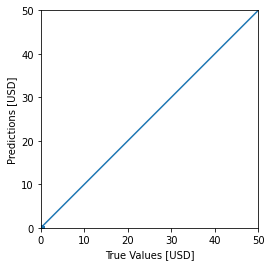

In [43]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [USD]')
plt.ylabel('Predictions [USD]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

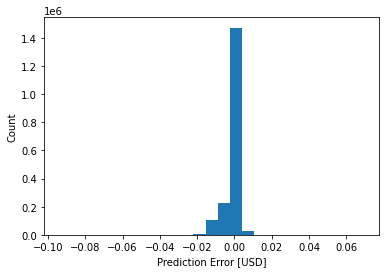

In [44]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [USD]')
_ = plt.ylabel('Count')

In [45]:
regression_metrics(test_predictions, test_labels)

MAE:  0.00215
MSE:  1e-05
RMSE:  0.003816108597573763
MAPE:  3.29053
